# Demonstration of `DroneWQ` functions and processing code

## Summary 

This notebook provides an example workflow of DroneWQ using multispectral images collected by the MicaSense RedEdge-MX sensor over western Lake Erie on August 17, 2022. The workflow processes raw imagery to remote sensing reflectance and applies bio-optical algorithms to retrieve chlorophyll a concentrations. It georeferences the images producing a final chlorophyll a mosaic of the full dataset. <br>

The Lake Erie drone dataset can be found in the [Zenodo DOI](https://doi.org/10.5281/zenodo.14018788), please note it is 5.84 GB unzipped. Depending on computer speed, you may need to subset the data before running the code workflow shown here. 

## Contents

1. [Setup](#1.-Setup)
2. [View metadata](#2.-View-metadata)
3. [Process raw to Rrs](#3.-Process-raw-imagery-to-remote-sensing-reflectance-(Rrs)-and-visualize-data)
4. [Convert to point samples](#4.-Convert-to-point-samples)
5. [Apply bio-optical algorithms](#5.-Apply-bio-optical-algorithms)
6. [Georeference and mosaic](#6.-Georeference-and-mosaic-chlorophyll-a-images)

## 1. Setup

Pull in all the libraries needed for this notebook.

In [1]:
import os
import dronewq
import glob
import numpy as np
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from cartopy.crs import Mercator

plt.rcParams['mathtext.default'] = 'regular'

Make sure your imagery has been manually organized into this exact structure (name the main_dir whatever you want but keep the rest exactly as named here):
```
    <main_dir>/
        raw_water_imgs/
        align_img/
        raw_sky_imgs/
        panel/
```

With that structure now just specify the path to your main_dir below. Here, we have the main_dir called 'Lake_Erie'.

In [2]:
dronewq.configure(main_dir='Lake_Erie')
settings = dronewq.settings

## 2. View metadata

MicaSense raw images contain metatdata including imager information, GPS coordianates, and more. We can use the `write_metadata_csv()` function to extract image metadata and save it as .csv. 

Let's open the first five lines of the .csv to take a look.

In [47]:
metadata_path = dronewq.write_metadata_csv(settings.raw_water_dir, settings.main_dir)

img_metadata = pd.read_csv(metadata_path)
img_metadata.head()

Loading ImageSet from: Lake_Erie/raw_water_imgs


filename                                 dirname   DateStamp  \
0  capture_1.tif  Lake_Erie/raw_water_imgs/capture_1.tif  2022-08-17   
1  capture_2.tif  Lake_Erie/raw_water_imgs/capture_2.tif  2022-08-17   
2  capture_3.tif  Lake_Erie/raw_water_imgs/capture_3.tif  2022-08-17   
3  capture_4.tif  Lake_Erie/raw_water_imgs/capture_4.tif  2022-08-17   
4  capture_5.tif  Lake_Erie/raw_water_imgs/capture_5.tif  2022-08-17   

  TimeStamp   Latitude LatitudeRef  Longitude LongitudeRef  Altitude  SensorX  \
0  15:37:04  41.828528           N -83.398762            W   265.061      4.8   
1  15:37:08  41.828670           N -83.398764            W   265.554      4.8   
2  15:37:10  41.828809           N -83.398760            W   265.968      4.8   
3  15:37:13  41.828956           N -83.398761            W   266.420      4.8   
4  15:37:16  41.829081           N -83.398763            W   267.018      4.8   

   ...  FocalLength         Yaw      Pitch        Roll  SolarElevation  \
0  ...      5.43432  218.376096  25.899967  335.837017        0.895362   
1  ...      5.43432  221.427592  16.821391  341.184053        0.895530   
2  ...      5.43432  218.898605  16.695405  343.643092        0.895655   
3  ...      5.43432  216.716936  18.188710  345.889851        0.895738   
4  ...      5.43432  214.429136  18.385695  347.772515        0.895863   

   ImageWidth  ImageHeight  XResolution  YResolution  ResolutionUnits  
0        1280          960   266.666667   266.666667               mm  
1        1280          960   266.666667   266.666667               mm  
2        1280          960   266.666667   266.666667               mm  
3        1280          960   266.666667   266.666667               mm  
4        1280          960   266.666667   266.666667               mm  

[5 rows x 21 columns]

We can plot the altitude and lat,lon, and yaw angle metadata of the image captures to get a sense of the flight plan.

Text(0, 0.5, 'Yaw')

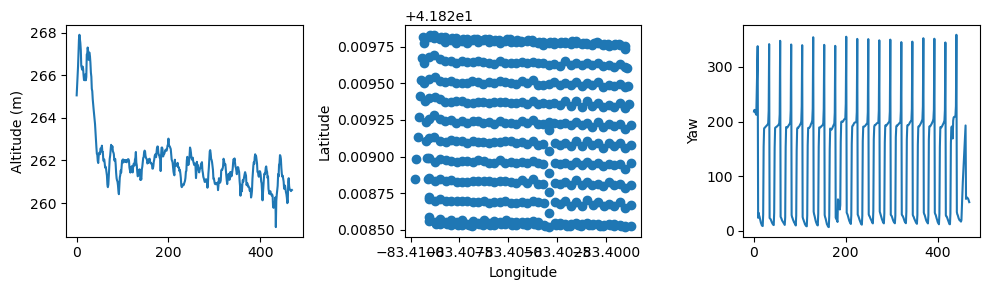

In [4]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='tight')

ax[0].plot(list(range(len(img_metadata))),img_metadata['Altitude'])
ax[0].set_ylabel('Altitude (m)')

ax[1].scatter(img_metadata['Longitude'], img_metadata['Latitude'])
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')

ax[2].plot(list(range(len(img_metadata))),img_metadata['Yaw'])
ax[2].set_ylabel('Yaw')

## 3. Process raw imagery to remote sensing reflectance (Rrs) and visualize data

Now let's get to processing. 
The `process_raw_to_rrs()` function has a number of options that you can see here:

In [5]:
?dronewq.process_raw_to_rrs

Signature:
dronewq.process_raw_to_rrs(
    output_csv_path: str,
    lw_method='mobley_rho',
    random_n=10,
    pixel_masking_method=None,
    mask_std_factor=1,
    nir_threshold=0.01,
    green_threshold=0.005,
    ed_method='dls_ed',
    overwrite_lt_lw=False,
    clean_intermediates=True,
    num_workers=4,
)
Docstring:
The main processing script that processs raw
imagery to units of remote sensing reflectance (Rrs). Users can
select which processing parameters to use to calculate Rrs.

Parameters
    output_csv_path: A string containing the filepath to write
        the metadata.csv

    lw_method: Method used to calculate water leaving radiance.
        Default is mobley_rho_method().

    random_n: The amount of random images to calculate ambient
        NIR level. Default is 10. Only need if lw_method = 'hedley_method'

    pixel_masking_method: Method to mask pixels. Options are
        'value_threshold', 'std_threshold', or None. Default is None.

    mask_std_factor: A fac

For this example, we're calculating water leaving radiance (Lw) using the Hedley approach and calculating downwelling irradiance (Ed) using the downwelling light sensor (DLS). We are applying the default masking procedure using a NIR threshold of 0.02. We'll save processed images out to two directories called `rrs_hedley` and `masked_rrs_hedley`. Please see the Processing and theory section in the [DroneWQ readthedocs](https://dronewq.readthedocs.io/en/latest/index.html) for more information on the different processing methods used here. 

In summary, this code will process: Raw -> Lt -> Lw (Hedley method) -> Rrs (using Ed from DLS) with pixel masking.

Note that we are changing the default nir_threshold for pixel masking from 0.01 to 0.02 since 0.01 was not high enough to mask glint pixels in this dataset. It is important to consider these values since they may change according to your dataset. 

In [5]:
dronewq.process_raw_to_rrs(output_csv_path=settings.main_dir, lw_method='hedley', 
                   random_n=10, pixel_masking_method='value_threshold', nir_threshold=0.02, ed_method='dls_ed', 
                   overwrite_lt_lw=False, clean_intermediates=False, num_workers=4)


2025-11-17 22:33:21,548 [INFO] dronewq.core.raw_to_rss: Processing a total of 2351 images or 470 captures.
2025-11-17 22:33:21,549 [INFO] dronewq.core.raw_to_rss: Converting raw images to radiance (raw -> Lt).


Loading ImageSet from: Lake_Erie/align_img
Loading ImageSet from: Lake_Erie/raw_water_imgs


2025-11-17 22:33:34,508 [INFO] dronewq.utils.images: Used warp dir: Lake_Erie/align_img


Loading ImageSet from: Lake_Erie/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes


/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/numpy/matrixlib/defmatrix.py:70: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


Finished aligning band 0


2025-11-17 22:33:42,032 [INFO] dronewq.utils.images: output_path: Lake_Erie/lt_imgs
2025-11-17 22:33:42,035 [INFO] dronewq.utils.images: Saving time: 0.00
2025-11-17 22:33:42,036 [INFO] dronewq.utils.images: Alignment+Saving rate: 0.00 images per second
2025-11-17 22:33:42,036 [INFO] dronewq.utils.images: Successfully processed: 0/0 captures
2025-11-17 22:33:42,036 [INFO] dronewq.utils.images: Finished saving images at: Lake_Erie/lt_imgs


Finished aligning band 2
Finished aligning band 4
Finished aligning band 1
Finished aligning band 3
Loading ImageSet from: Lake_Erie/raw_water_imgs


2025-11-17 22:33:54,476 [INFO] dronewq.utils.images: Finished saving image metadata at: Lake_Erie/lt_imgs/metadata.csv
2025-11-17 22:33:54,490 [INFO] dronewq.core.raw_to_rss: Applying the Hochberg/Hedley (Lt -> Lw)
/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **k

Loading ImageSet from: Lake_Erie/raw_water_imgs


2025-11-17 22:36:15,954 [INFO] dronewq.ed_methods.dls_ed: Ed Stage (DLS): Successfully processed: 470/470 captures
2025-11-17 22:36:15,965 [INFO] dronewq.core.raw_to_rss: All data has been saved as Rrs using the hedley to            calculate Lw and normalized by dls_ed irradiance.
2025-11-17 22:36:15,965 [INFO] dronewq.core.raw_to_rss: Masking pixels using NIR and green Rrs thresholds
2025-11-17 22:37:11,749 [INFO] dronewq.masks.threshold_masking: Masking Stage (threshold_masking): Successfully processed: 470 captures


To grab these processed images and their metadata you can use the helper function `retrieve_imgs_and_metadata()`. The images can also easily be loaded in with the lower level `load_images()` function or even just with rasterio's `open()` function but the higher level `retrieve_imgs_and_metadata()` allows you to apply an altitude cutoff and limit the number of files being opened. In the case of large processing jobs it will likely be more appropriate to loop through the files individually or in batches which can be done by looping the `start` and `count` arguments in `retrieve_imgs_and_metadata()`.

In [ ]:
?dronewq.load_imgs

Signature:
dronewq.load_imgs(
    img_dir,
    count=10000,
    start=0,
    altitude_cutoff=0,
    random=False,
)
Docstring:
This function loads all images in a directory as a multidimensional numpy array.

Parameters
    img_dir: A string containing the directory filepath of images to be retrieved

Returns
    An iterator over numpy arrays of all image captures in a directory
File:      ~/Developer/GitHub/DroneWQ/src/dronewq/utils/images.py
Type:      function

In [37]:
?dronewq.load_metadata

Signature:
dronewq.load_metadata(
    img_dir,
    count=10000,
    start=0,
    altitude_cutoff=0,
    random=False,
)
Docstring:
This function returns a pandas dataframe of captures and associated metadata with the options of how many to list and what number of image to start on.

Parameters
    img_dir: A string containing the directory filepath of images to be retrieved

    count: The amount of images to load. Default is 10000

    start: The image to start loading from. Default is 0 (first image the .csv).

    random: A boolean to load random images. Default is False

Returns
    Pandas dataframe of image metadata
File:      ~/Developer/GitHub/DroneWQ/src/dronewq/utils/images.py
Type:      function

Let's retrieve the Rrs data (5 bands) and visualize the first 5 images:

Index(['capture_1.tif', 'capture_2.tif', 'capture_3.tif', 'capture_4.tif',
       'capture_5.tif'],
      dtype='object', name='filename')


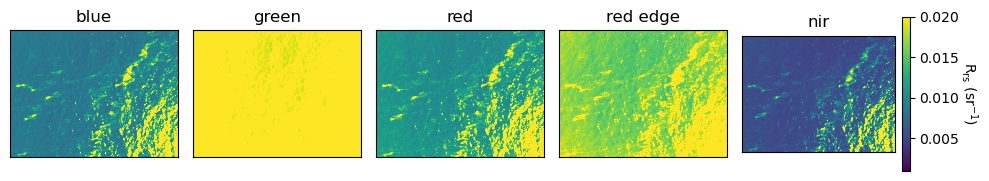

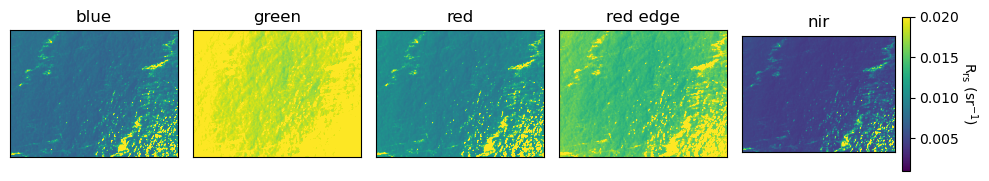

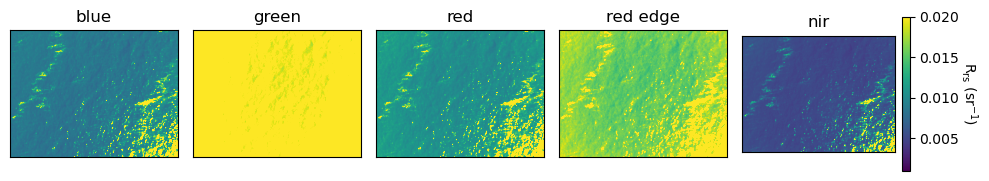

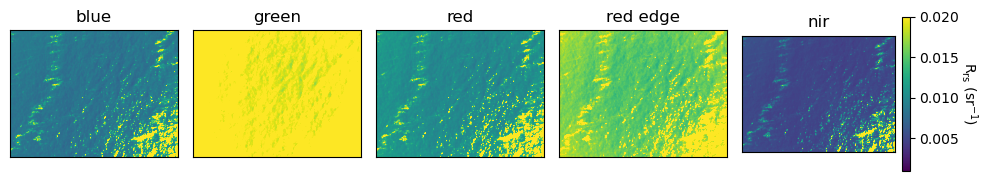

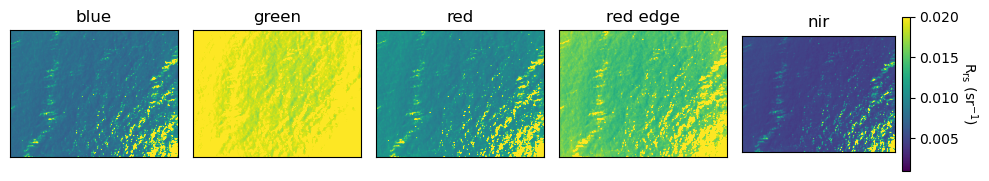

In [ ]:
rrs_imgs_hedley_gen = dronewq.load_imgs(img_dir=settings.rrs_dir, start=0, count=5)

img_metadata = dronewq.load_metadata(img_dir=settings.rrs_dir, count=5)

# you can convert the generator to a list or array if needed
rrs_imgs_hedley = np.array(list(rrs_imgs_hedley_gen))

print(img_metadata.index)

band_names = ['blue', 'green', 'red', 'red edge', 'nir']

for j in range(len(rrs_imgs_hedley[0:5])):
    fig, ax = plt.subplots(1,5, figsize=(10,3.5))
    for i in range(5):
        im = ax[i].imshow(rrs_imgs_hedley[j,i], cmap='viridis', vmin=0.001, vmax=0.02)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    cbar = fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
    cbar.set_label(r'$R_{rs}\ (sr^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 
    plt.show()

We can also visualize the masked Rrs:

Index(['capture_1.tif', 'capture_2.tif', 'capture_3.tif', 'capture_4.tif',
       'capture_5.tif'],
      dtype='object', name='filename')


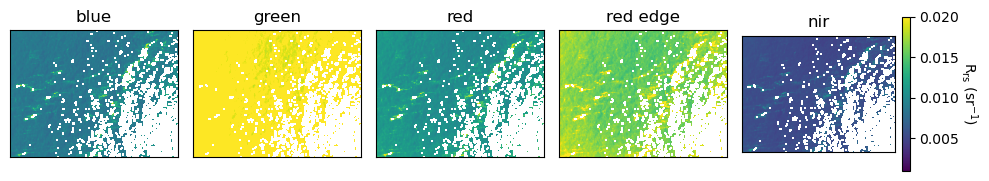

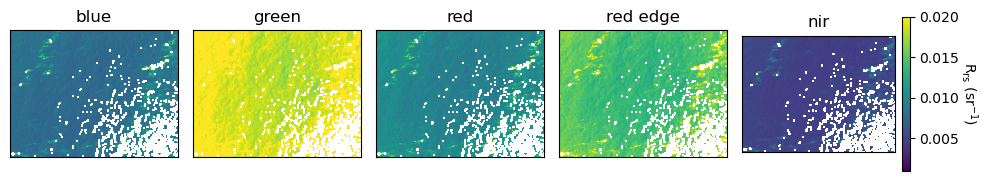

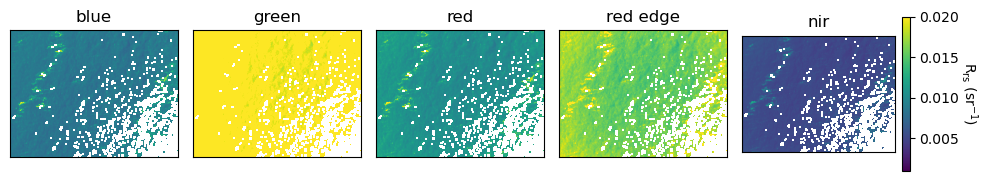

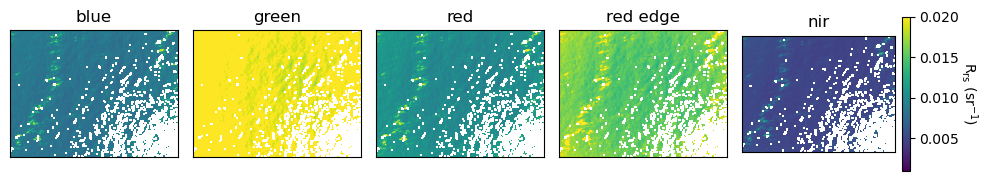

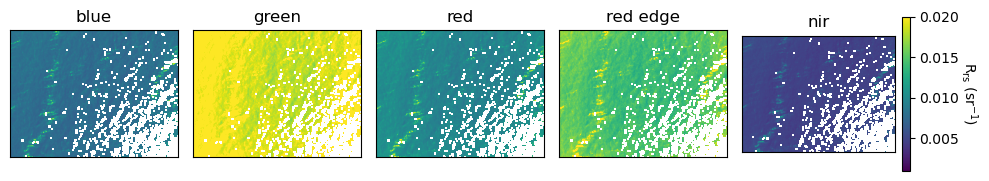

In [9]:
masked_rrs_imgs_hedley_gen = dronewq.load_imgs(img_dir=settings.masked_rrs_dir, start=0, count=5)

img_metadata = dronewq.load_metadata(img_dir=settings.masked_rrs_dir, count=5)

masked_rrs_imgs_hedley = np.array(list(masked_rrs_imgs_hedley_gen))

print(img_metadata.index)

for j in range(len(masked_rrs_imgs_hedley[0:5])):
    fig, ax = plt.subplots(1,5, figsize=(10,3.5))
    for i in range(5):
        im = ax[i].imshow(masked_rrs_imgs_hedley[j,i],cmap='viridis', vmin=0.001, vmax=0.02)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    cbar = fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
    cbar.set_label(r'$R_{rs}\ (sr^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 
    plt.show()

Let's plot the masked Rrs spectra of the first 25 images:

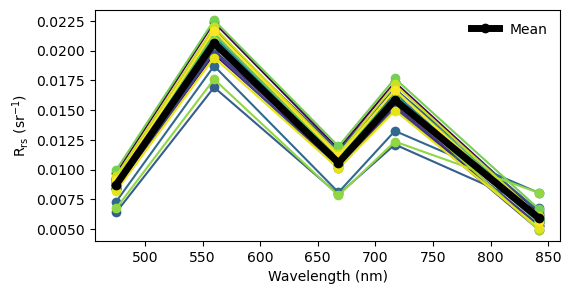

In [12]:
masked_rrs_imgs_hedley_gen = dronewq.load_imgs(img_dir = settings.masked_rrs_dir, count=25)

masked_rrs_imgs_hedley = np.array(list(masked_rrs_imgs_hedley_gen))

fig, ax = plt.subplots(1,1, figsize=(6,3))

wv = [475, 560, 668, 717, 842]

color_map = plt.get_cmap("viridis")
colors = [color_map(i) for i in np.linspace(0, 1, len(masked_rrs_imgs_hedley))]

for i in range(len(masked_rrs_imgs_hedley)):
    plt.plot(wv, np.nanmean(masked_rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)), marker = 'o', color=colors[i], label="")
    plt.xlabel('Wavelength (nm)')
    plt.ylabel(r'$R_{rs}\ (sr^{-1}$)') 
plt.plot(wv, np.nanmean(masked_rrs_imgs_hedley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Mean')

plt.legend(frameon=False)

Let's compare this Rrs spectra to Rrs spectra retrived by a satellite at the same location and time. Below is a plot of Rrs from the Ocean Land Color Imager (OLCI) on board the European satellite, Sentinel-3A. OLCI collects in a few more bands which is why there are more points on the plot. However, the shape looks similar to the MicaSense retrieved Rrs. The troughs at 475 nm and 668 nm is associated with chlorophyll absorption and the peak at 717 nm is likely due to phytoplankton particle scattering. 

<img src="figs/OLCI_Rrs_Lake_Erie.png" width=560 height=500/>

Let's plot the Lt, Lw, Ed spectra as well. First, we need to retrieve all the data.

In [18]:
lt_imgs = dronewq.load_imgs(img_dir = settings.lt_dir, count=25)
lw_imgs = dronewq.load_imgs(img_dir = settings.lw_dir, count=25)
csv_path = os.path.join(settings.main_dir, 'dls_ed.csv')
dls_ed = pd.read_csv(csv_path)
rrs_imgs_hedley = dronewq.load_imgs(img_dir = settings.rrs_dir, count=25)
masked_rrs_imgs_hedley = dronewq.load_imgs(img_dir = settings.masked_rrs_dir, count=25)

/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


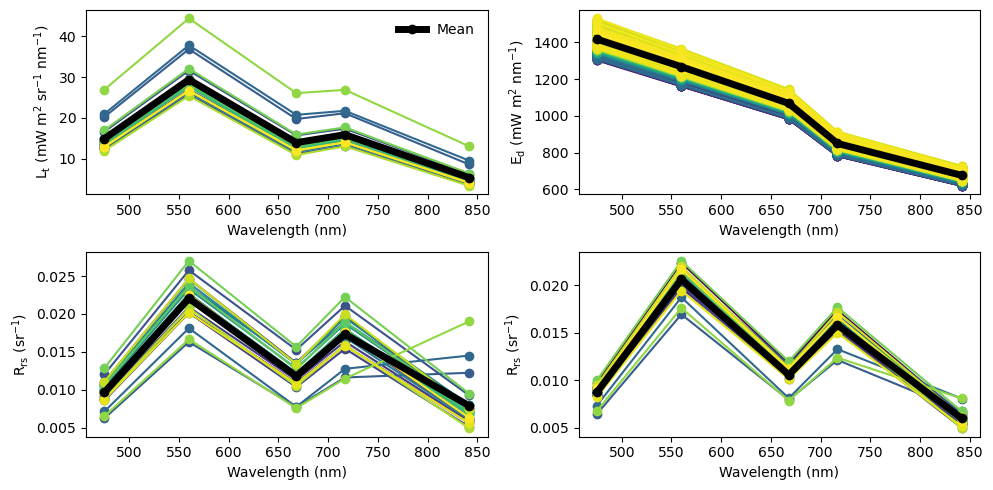

In [19]:
fig, axs = plt.subplots(2,2, figsize=(10,5))

axs = axs.ravel()

wv = [475, 560, 668, 717, 842]
colors = plt.get_cmap("viridis")(np.linspace(0,1,25))

#lt
total_mean = []
for i, img in enumerate(lt_imgs):
    img_mean = np.nanmean(img[0:5,:,:], axis=(1,2))
    total_mean.append(img_mean)
    axs[0].plot(wv, img_mean,  marker = 'o', color=colors[i], label="")
    axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel(r'$L_t\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)')   
axs[0].plot(wv, np.mean(total_mean, axis=0),  marker = 'o', color='black', linewidth=5, label='Mean')
axs[0].legend(frameon=False)

#dls ed
dls_colors = plt.get_cmap("viridis")(np.linspace(0,1,len(dls_ed)))

for i in range(len(dls_ed)):
    axs[1].plot(wv, dls_ed.iloc[i,1:6],  marker = 'o', color=dls_colors[i]) 
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel(r'$E_d\ (mW\ m^2\ nm^{-1}$)') 
axs[1].plot(wv, dls_ed.iloc[:,1:6].mean(axis=0),  marker = 'o', color='black', linewidth=5, label='Mean')

#rrs_imgs_hedley
total_mean = []
for i, img in enumerate(rrs_imgs_hedley):
    img_mean = np.nanmean(img[0:5,:,:],axis=(1,2))
    total_mean.append(img_mean)
    axs[2].plot(wv, img_mean,  marker = 'o', color=colors[i], label="")
    axs[2].set_xlabel('Wavelength (nm)')
    axs[2].set_ylabel(r'$R_{rs}\ (sr^{-1}$)') 
axs[2].plot(wv, np.mean(total_mean, axis=0),  marker = 'o', color='black', linewidth=5, label='Mean')


#rrs_imgs_hedley_masked
total_mean = []
for i, img in enumerate(masked_rrs_imgs_hedley):
    img_mean = np.nanmean(img[0:5,:,:],axis=(1,2))
    total_mean.append(img_mean)
    axs[3].plot(wv, img_mean,  marker = 'o', color=colors[i], label="")
    axs[3].set_xlabel('Wavelength (nm)')
    axs[3].set_ylabel(r'$R_{rs}\ (sr^{-1}$)')   
axs[3].plot(wv, np.mean(total_mean, axis=0),  marker = 'o', color='black', linewidth=5, label='Mean')

fig.tight_layout() 

The `process_raw_to_rrs()` function also saves images processed to total radiance (Lt) as stacked red-green-blue (RGB) .jpg's in a folder called 'lt_thumbnails'. This is an easy way to quickly view the images to see what the water surface looked like. Let's open a few to take a look:

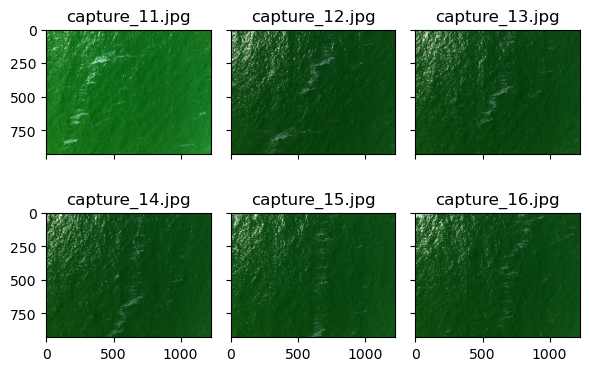

In [20]:
def capture_path_to_int(path : str) -> int:
    return int(os.path.basename(path).split('_')[-1].split('.')[0])

thumbnail_path = os.path.join(settings.main_dir, 'lt_thumbnails')
lt_thumbnails = sorted(glob.glob(thumbnail_path + '/*.jpg'), key = capture_path_to_int)[10:]

fig, axs = plt.subplots(2,3, figsize=(6,4), sharex=True, sharey=True, layout='tight')
axs = axs.ravel()

for i in range(6):
    image = mpimg.imread(lt_thumbnails[i])
    axs[i].imshow(image)
    axs[i].set_title(os.path.basename(lt_thumbnails[i]))

plt.show()

## 4. Convert to point samples

You might be interested in averaging values for every image, to work with point samples. This code calculates the median Rrs across bands and saves them to a Pandas dataframe with the dirname, lat, and lon.

In [22]:
masked_rrs_imgs_hedley = dronewq.load_imgs(img_dir = settings.masked_rrs_dir)
img_metadata = dronewq.load_metadata(img_dir = settings.masked_rrs_dir)

# Compute per-image median for first 5 bands (shape -> (n_images, 5))
# We take median across spatial dims (H, W)
medians = []
for img in masked_rrs_imgs_hedley:
    med = np.nanmedian(img[:5, :, :], axis=(1, 2))
    # Handle the all-NaN case here
    if np.isnan(med).all():
        med = np.zeros(5)  # or any default value
    medians.append(med)

# Build dataframe safely and assign median band values
df = img_metadata[['dirname', 'Latitude', 'Longitude']].copy()
df[['rrs_blue', 'rrs_green', 'rrs_red', 'rrs_rededge', 'rrs_nir']] = medians

# Show result
df.head()


/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


dirname   Latitude  Longitude  \
filename                                                                      
capture_1.tif  Lake_Erie/raw_water_imgs/capture_1.tif  41.828528 -83.398762   
capture_2.tif  Lake_Erie/raw_water_imgs/capture_2.tif  41.828670 -83.398764   
capture_3.tif  Lake_Erie/raw_water_imgs/capture_3.tif  41.828809 -83.398760   
capture_4.tif  Lake_Erie/raw_water_imgs/capture_4.tif  41.828956 -83.398761   
capture_5.tif  Lake_Erie/raw_water_imgs/capture_5.tif  41.829081 -83.398763   

               rrs_blue  rrs_green   rrs_red  rrs_rededge   rrs_nir  
filename                                                             
capture_1.tif  0.008884   0.021376  0.010884     0.016411  0.005573  
capture_2.tif  0.007873   0.019060  0.009792     0.014552  0.004788  
capture_3.tif  0.008723   0.021184  0.010774     0.016163  0.005337  
capture_4.tif  0.008549   0.020580  0.010432     0.015699  0.005169  
capture_5.tif  0.007984   0.019396  0.009969     0.014781  0.004904

Easy to save as a .csv:

In [23]:
median_rrs_path = os.path.join(settings.main_dir, 'median_rrs.csv')
df.to_csv(median_rrs_path)

## 5. Apply bio-optical algorithms

We can also apply bio-optical algorithms to derive chlorophyll a and total suspended matter (TSM) concentrations. Please see the Processing and theory section in the [DroneWQ readthedocs](https://dronewq.readthedocs.io/en/latest/index.html) for more information on each algorithm. Here, we are applying the blended NASA chlorophyll a algorithm (Hu et al., 2019). 

In [24]:
masked_rrs_imgs_hedley = dronewq.load_imgs(img_dir = settings.masked_rrs_dir)
    
chl_hu_ocx_values = []
for img in masked_rrs_imgs_hedley:
    result = dronewq.chl_hu_ocx(img)
    chl_hu_ocx_values.append(result)

chl_hu_ocx_values = np.array(chl_hu_ocx_values)
print(chl_hu_ocx_values.shape)

/Users/artemis/Developer/GitHub/DroneWQ/src/dronewq/core/wq_calc.py:170: RuntimeWarning: invalid value encountered in log10
  temp = np.log10(Rrsblue / Rrsgreen)
/Users/artemis/Developer/GitHub/DroneWQ/src/dronewq/core/wq_calc.py:170: RuntimeWarning: divide by zero encountered in log10
  temp = np.log10(Rrsblue / Rrsgreen)
/Users/artemis/Developer/GitHub/DroneWQ/src/dronewq/core/wq_calc.py:172: RuntimeWarning: invalid value encountered in add
  log10chl = a0 + a1 * (temp) + a2 * (temp) ** 2 + a3 * (temp) ** 3 + a4 * (temp) ** 4


(470, 928, 1227)


Let's take a quick look at a histogram of all chl values:

10.45272


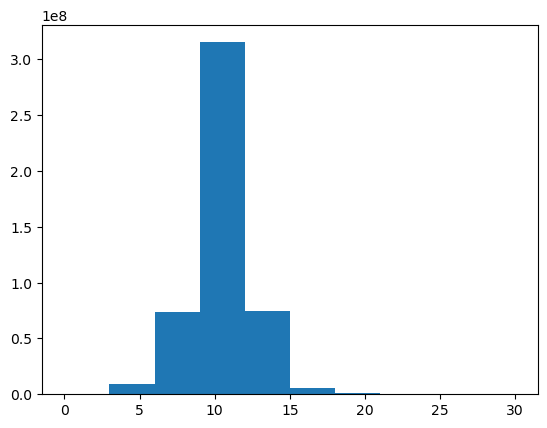

In [25]:
plt.hist(chl_hu_ocx_values.ravel(), range=(0, 30))
print(np.nanmedian(chl_hu_ocx_values))

In [26]:
# Cleanup Memory
del chl_hu_ocx_values

The median value looks to be around 11 mg $m^{-3}$, which is reasonable for Lake Erie. 

Now, we can save new .tifs processed with this algorithm. 

In [27]:
dronewq.save_wq_imgs(rrs_dir = settings.masked_rrs_dir, wq_algs = ['chl_hu_ocx'])

/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/opt/anaconda3/envs/dronewq/lib

Let's visualize a few chl a images.

Index(['capture_1.tif', 'capture_2.tif', 'capture_3.tif', 'capture_4.tif',
       'capture_5.tif', 'capture_6.tif'],
      dtype='object', name='filename')


/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


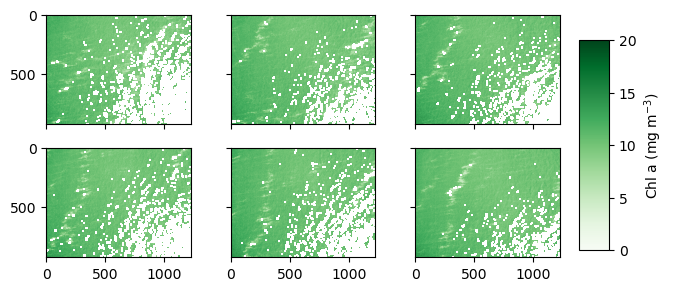

In [28]:
chl_imgs = dronewq.load_imgs(img_dir = settings.chl_hu_ocx_dir, start=0, count=6)
img_metadata = dronewq.load_metadata(img_dir = settings.chl_hu_ocx_dir, count=6)
print(img_metadata.index)

fig, axs = plt.subplots(2,3, figsize=(6,3), sharex=True, sharey=True, layout='tight')

axs = axs.ravel()

for i, img in enumerate(chl_imgs):
    im = axs[i].imshow(img[0,:,:], cmap='Greens', vmin=0, vmax=20)

cbar_ax = fig.add_axes((0.99, 0.15, 0.05, 0.7))
fig.colorbar(im, cax=cbar_ax, label='Chl a (mg $m^{-3}$)')  

plt.show()

We can also save average chl-a/TSM concentrations for each image in dataframe to use as point data:

In [29]:
df = pd.read_csv(median_rrs_path)
masked_rrs_imgs_hedley = dronewq.load_imgs(img_dir = settings.masked_rrs_dir)

chl_hu_ocx_imgs = []
tsm_nechad_imgs = []
for img in masked_rrs_imgs_hedley:
    chl_median = np.nanmedian(dronewq.chl_hu_ocx(img), axis=(0,1))
    tsm_median = np.nanmedian(dronewq.tsm_nechad(img), axis=(0,1))
    chl_hu_ocx_imgs.append(chl_median)
    tsm_nechad_imgs.append(tsm_median)

chl_hu_ocx_imgs = np.array(chl_hu_ocx_imgs)
tsm_nechad_imgs = np.array(tsm_nechad_imgs)

print(chl_hu_ocx_imgs.shape)
print(tsm_nechad_imgs.shape)

df['chl_hu_ocx'] = chl_hu_ocx_imgs
df['tsm_nechad'] = tsm_nechad_imgs

del chl_hu_ocx_imgs
del tsm_nechad_imgs

df.head()

/Users/artemis/Developer/GitHub/DroneWQ/src/dronewq/core/wq_calc.py:170: RuntimeWarning: invalid value encountered in log10
  temp = np.log10(Rrsblue / Rrsgreen)
/Users/artemis/Developer/GitHub/DroneWQ/src/dronewq/core/wq_calc.py:170: RuntimeWarning: divide by zero encountered in log10
  temp = np.log10(Rrsblue / Rrsgreen)
/Users/artemis/Developer/GitHub/DroneWQ/src/dronewq/core/wq_calc.py:172: RuntimeWarning: invalid value encountered in add
  log10chl = a0 + a1 * (temp) + a2 * (temp) ** 2 + a3 * (temp) ** 3 + a4 * (temp) ** 4


(470,)
(470,)


/var/folders/2l/s8y6f4p14b74wlj3ndj8xhsr0000gn/T/ipykernel_27847/4085239826.py:7: RuntimeWarning: All-NaN slice encountered
  chl_median = np.nanmedian(dronewq.chl_hu_ocx(img), axis=(0,1))


filename                                 dirname   Latitude  \
0  capture_1.tif  Lake_Erie/raw_water_imgs/capture_1.tif  41.828528   
1  capture_2.tif  Lake_Erie/raw_water_imgs/capture_2.tif  41.828670   
2  capture_3.tif  Lake_Erie/raw_water_imgs/capture_3.tif  41.828809   
3  capture_4.tif  Lake_Erie/raw_water_imgs/capture_4.tif  41.828956   
4  capture_5.tif  Lake_Erie/raw_water_imgs/capture_5.tif  41.829081   

   Longitude  rrs_blue  rrs_green   rrs_red  rrs_rededge   rrs_nir  \
0 -83.398762  0.008884   0.021376  0.010884     0.016411  0.005573   
1 -83.398764  0.007873   0.019060  0.009792     0.014552  0.004788   
2 -83.398760  0.008723   0.021184  0.010774     0.016163  0.005337   
3 -83.398761  0.008549   0.020580  0.010432     0.015699  0.005169   
4 -83.398763  0.007984   0.019396  0.009969     0.014781  0.004904   

   chl_hu_ocx  tsm_nechad  
0   10.093154    5.684309  
1   10.338958    5.275489  
2   10.424445    5.643196  
3   10.240140    5.514975  
4   10.452680    5.341609

Easy to save as .csv:

In [30]:
# Save as csv
median_rrs_wq_path = os.path.join(settings.main_dir, 'median_rrs_and_wq.csv')
df.to_csv(median_rrs_wq_path)

We can use this dataframe to map point samples of mean chl-a and TSM concentrations:

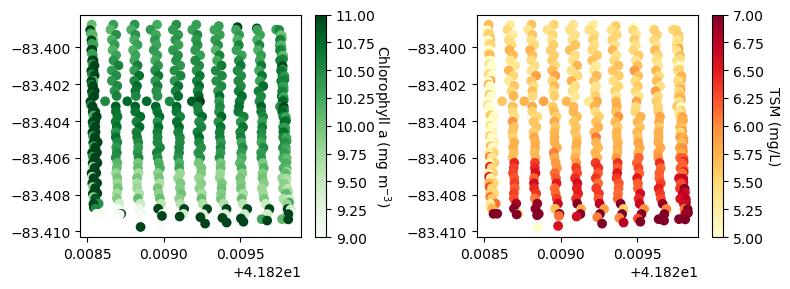

In [36]:
df = pd.read_csv(median_rrs_wq_path)
fig, ax = plt.subplots(1,2, figsize=(8,3), layout='tight')
g1 = ax[0].scatter(df['Latitude'], df['Longitude'], c=df['chl_hu_ocx'], cmap='Greens', vmin=9, vmax=11)
g2 = ax[1].scatter(df['Latitude'], df['Longitude'], c=df['tsm_nechad'], cmap='YlOrRd', vmin=5, vmax=7)

cbar = fig.colorbar(g1, ax=ax[0])
cbar.set_label('Chlorophyll a (mg $m^{-3}$)', rotation=270, labelpad=12)
cbar = fig.colorbar(g2, ax=ax[1])
cbar.set_label('TSM (mg/L)', rotation=270, labelpad=12)

plt.show()

## 6. Georeference and mosaic chlorophyll a images

We can georeference the images based on the sensor yaw, pitch, roll, lat, lon, and altitude. Note that georeferencing can be inaccurate if the yaw, pitch, and roll information is imprecise. Let's look at the options in the `georeference()` function.

In [37]:
?dronewq.georeference

Signature:
dronewq.georeference(
    metadata,
    input_dir,
    output_dir,
    lines=None,
    altitude=None,
    yaw=None,
    pitch=0,
    roll=0,
    axis_to_flip=1,
) -> None
Docstring:
This function georeferences all the captures indicated in
the line parameter following the specification of the other
parameters such as altitude, yaw, pitch, roll, axis_to_flip

Parameters
----------
    metadata: A Pandas dataframe of the metadata

    input_dir: A string containing the directory filepath
        of the images to be retrieved for georeferencing.

    output_dir: A string containing the directory filepath
        to be saved.

    lines: Selection of images to be processed.
        Defaults to None. Example: [slice(0,10)]

    altitude: sets the altitude where all captures were taken.
        Defaults to None which uses the altitude data saved in
        the metadata for each respective capture.

    yaw: sets the sensor's direction angle during all captures.
        Defaults to

We have two options here. We can set fixed georeferencing parameters, or allow the function to use parameters saved in the metadata.

In this example, the image metadata lists the altitude around 260-265 m; however, the altitude was set at 87 m in the flight planning software. Therefore, we will set the altitude to a fixed altitude of 87 m. 

If you can maintain a consistent sensor yaw angle throughout the whole flight, you should use a single fixed angle. If your sensor changes yaw angle during every transect (such as in this example), a different yaw angle should be provided in the function for each transect. The `georeference()` function can read in a `lines` parameter that can be created either manually or you can use the function `compute_flight_lines()` to automatically produce a list of capture indices per transect with the median yaw angle, ignoring capturing collected during turns. More information can be found in the Processing and theory section in the [DroneWQ readthedocs](https://dronewq.readthedocs.io/en/latest/index.html).

It is recommended to run the `georeference()` function on a few captures that contain a shoreline or land if possible and plot them with a satellite basemap or pull them into a GIS software to assess the georeferencing. We have provided examples here by manually creating a new folder of rrs_hedley_subset and lt_thumbnails_subset with captures 433 to 450 containing the shoreline.

1. Running `georeference()` with the automatic `compute_flight_lines()` function produces a flight_lines list with yaw angle changing from 207 to 25 degrees:

In [43]:
hedley_subset_path = os.path.join(settings.main_dir, 'rrs_hedley_subset')
img_metadata = dronewq.load_metadata(img_dir = hedley_subset_path, start=432, count=18)
img_metadata = img_metadata.reset_index()

flight_lines = dronewq.compute_flight_lines(img_metadata.Yaw, 87, 0, 0, threshold=100)
flight_lines

[{'start': 0,
  'end': 9,
  'yaw': 207.89967631978038,
  'pitch': 0,
  'roll': 0,
  'alt': 87},
 {'start': 10,
  'end': 18,
  'yaw': 25.85588214075483,
  'pitch': 0,
  'roll': 0,
  'alt': 87}]

We can edit the metadata to change file extension from '.tif' to '.jpg' and run `georeference()` on the lt_thumbnails_subset:

In [44]:
img_metadata['filename'] = img_metadata['filename'].apply(lambda x : x.replace('.tif', '.jpg')) 

input_dir = os.path.join(settings.main_dir, 'lt_thumbnails_subset') 
output_dir = os.path.join(settings.main_dir, 'automatic_georeferenced_lt_thumbnails_subset')
lines = flight_lines

dronewq.georeference(img_metadata, input_dir, output_dir, lines) 

  0%|          | 0/17 [00:00<?, ?it/s]/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 17/17 [00:00<00:00, 33.91it/s]


When we plot these images in QGIS, it looks like: <br>
<img src="figs/automatic_flightlines_QGIS.png" width=400 height=200/>

You can see that using the metadata yaw angle in georeferencing doesn't always lead to accurate georeferencing. 

2. Running `georeference()` using fixed yaw angles of 90 and 270 degrees:

In [45]:
flight_lines = dronewq.compute_flight_lines(img_metadata.Yaw, 87, 0, 0, threshold=100)

even_yaw = 90
odd_yaw = 270
threshold = np.median(img_metadata.Yaw)
for line in flight_lines:
    line.update(yaw = even_yaw if line['yaw'] < threshold else odd_yaw)
    
flight_lines

[{'start': 0, 'end': 9, 'yaw': 270, 'pitch': 0, 'roll': 0, 'alt': 87},
 {'start': 10, 'end': 18, 'yaw': 90, 'pitch': 0, 'roll': 0, 'alt': 87}]

In [46]:
input_dir = os.path.join(settings.main_dir, 'lt_thumbnails_subset') 
output_dir = os.path.join(settings.main_dir, 'manual_georeferenced_lt_thumbnails_subset')
lines = flight_lines

dronewq.georeference(img_metadata, input_dir, output_dir, lines) 

  0%|          | 0/17 [00:00<?, ?it/s]/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 17/17 [00:00<00:00, 39.63it/s]


When we plot these images in QGIS: <br>
<img src="figs/manual_flightlines_QGIS.png" width=400 height=200/>

You can see that using these fixed yaw angles leads to better georeferencing where the shoreline better matches to the satellite basemap.

Therefore, we will use fixed yaw angles of 90 and 270 degrees to georeference the masked_chl_hu_ocx_imgs:

In [48]:
metadata = pd.read_csv(metadata_path)

flight_lines = dronewq.compute_flight_lines(metadata.Yaw, 87, 0, 0)   
even_yaw = 90
odd_yaw = 270
threshold = np.median(metadata.Yaw)
for line in flight_lines:
    line.update(yaw = even_yaw if line['yaw'] < threshold else odd_yaw)
flight_lines[0:5]

[{'start': 11, 'end': 17, 'yaw': 90, 'pitch': 0, 'roll': 0, 'alt': 87},
 {'start': 22, 'end': 32, 'yaw': 270, 'pitch': 0, 'roll': 0, 'alt': 87},
 {'start': 34, 'end': 42, 'yaw': 90, 'pitch': 0, 'roll': 0, 'alt': 87},
 {'start': 46, 'end': 56, 'yaw': 270, 'pitch': 0, 'roll': 0, 'alt': 87},
 {'start': 58, 'end': 66, 'yaw': 90, 'pitch': 0, 'roll': 0, 'alt': 87}]

In [49]:
input_dir = os.path.join(settings.main_dir, 'masked_chl_hu_ocx_imgs') 
output_dir = os.path.join(settings.main_dir, 'georeferenced_masked_chl_hu_ocx')
lines = flight_lines

dronewq.georeference(metadata, input_dir, output_dir, lines) 

100%|██████████| 328/328 [00:05<00:00, 56.21it/s]


Let's plot a few of these georeferenced images by the shoreline:

/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)
/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


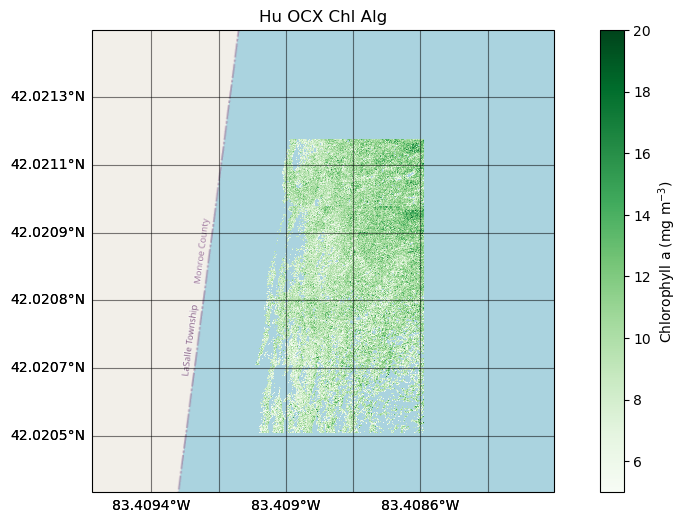

In [52]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))
ax_0, mappable_0 = dronewq.plot_georeferenced_data(ax=ax, filename="Lake_Erie/georeferenced_masked_chl_hu_ocx/capture_444.tif", 
                                           vmin=5, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)

ax_0, mappable_0 = dronewq.plot_georeferenced_data(ax=ax, filename="Lake_Erie/georeferenced_masked_chl_hu_ocx/capture_445.tif", 
                                           vmin=5, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)

ax_0.set_title('Hu OCX Chl Alg')
plt.colorbar(mappable_0, label='Chlorophyll a (mg $m^{-3}$)')

We can mosaic all of the individual georeferenced images. Let's look at the options.

In [ ]:
?mosaic

We will make a mosaic from all the georeferenced chl images, calculating the mean of overlapping pixels. 

In [53]:
input_dir = os.path.join(settings.main_dir, 'georeferenced_masked_chl_hu_ocx')
output_dir = os.path.join(settings.main_dir, 'mosaic_chl_hu_ocx')

dronewq.mosaic(input_dir, output_dir, output_name = 'mean_mosaic_chl_hu_ocx',
           method='mean', band_names = None) 

100%|██████████| 328/328 [03:59<00:00,  1.37it/s]
/Users/artemis/Developer/GitHub/DroneWQ/src/dronewq/core/mosaic_methods.py:210: RuntimeWarning: invalid value encountered in divide
  return np.divide(final_data, count)


'Lake_Erie/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx.tif'

Now let's plot the mosaicked image.

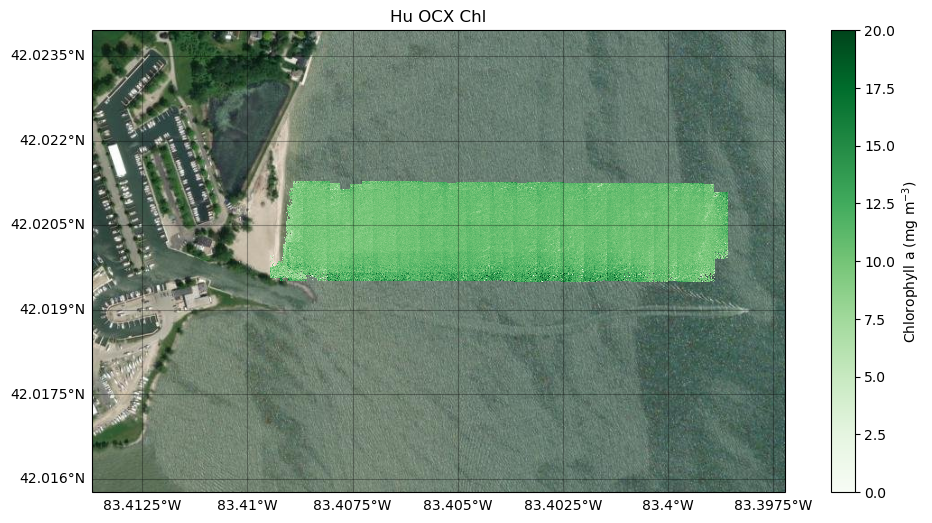

In [54]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))
ax_0, mappable_0 = dronewq.plot_georeferenced_data(ax=ax, filename="Lake_Erie/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx.tif", 
                                           vmin=0, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.Esri.WorldImagery)
ax_0.set_title('Hu OCX Chl')
plt.colorbar(mappable_0, label='Chlorophyll a (mg $m^{-3}$)')

We can also downsample or reduce the spatial resolution of the mosaic. This is helpful to reduce the file size of a large mosaic. 

In [55]:
?dronewq.downsample

Signature:
dronewq.downsample(
    input_tif,
    output_dir,
    scale_x,
    scale_y,
    method=<Resampling.average: 5>,
)
Docstring:
This function performs a downsampling to reduce the spatial resolution of
the final mosaic. The downsampled raster is written to output_dir.

Parameters
    input_dir: A string containing input directory filepath

    output_dir: A string containing output directory filepath

    scale_x: proportion by which the width of each file will be resized

    scale_y: proportion by which the height of each file will be resized

    method: the resampling method to perform.
        Defaults to Resampling.average
        Please see `https://rasterio.readthedocs.io/en/stable/api/rasterio.enums.html#rasterio.enums.Resampling`
        for other resampling methods.
File:      ~/Developer/GitHub/DroneWQ/src/dronewq/core/mosaic.py
Type:      function

We will downsample the width and height of the mosaic by 15%, using a nearest neighbor resampling algorithm. 

In [57]:
from rasterio.enums import Resampling

input_dir = os.path.join(settings.main_dir, 'mosaic_chl_hu_ocx', "mean_mosaic_chl_hu_ocx.tif")
output_dir = os.path.join(settings.main_dir, 'mosaic_chl_hu_ocx')

dronewq.downsample(input_dir, output_dir, scale_x = 15, scale_y = 15, method = Resampling.nearest)

'Lake_Erie/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx_x_15_y_15_method_nearest.tif'

And we can plot it

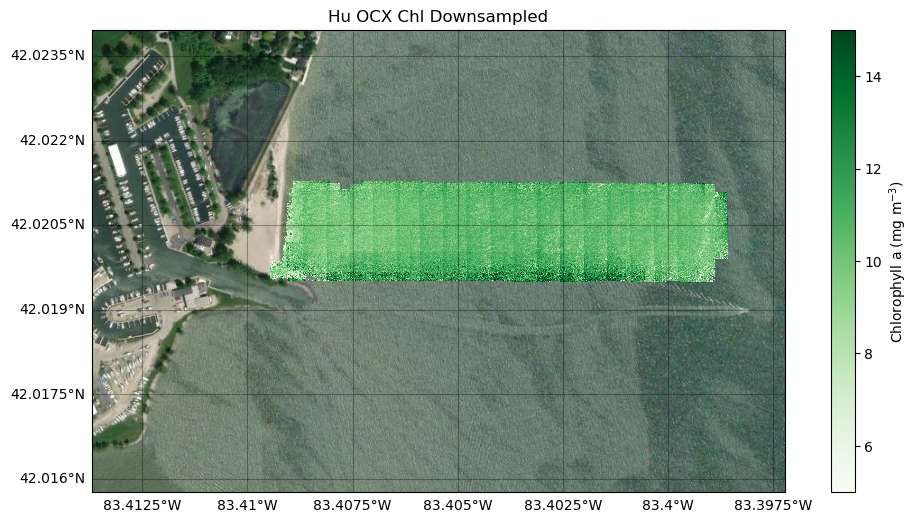

In [58]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))
ax_0, mappable_0 = dronewq.plot_georeferenced_data(ax=ax, filename="Lake_Erie/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx_x_15_y_15_method_nearest.tif", 
                                           vmin=5, vmax=15, cmap='Greens', norm=None, basemap = cx.providers.Esri.WorldImagery)
ax_0.set_title('Hu OCX Chl Downsampled')
plt.colorbar(mappable_0, label='Chlorophyll a (mg $m^{-3}$)')

Some striping in the mosaic is visible due to the drone/sensor changing yaw angles every transect. Processing and mosaicking a larger dataset has the potential to reveal water quality patterns or algal blooms. 